In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("derrom/")
sys.path.append("ELPH/")
sys.path.append("utils/")

import derrom
import ivp_integrator
import PHELPH

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
trajectories = derrom.utils.load_trajectories(filename='../trajectories_n_kmax=200.npz')
derivs = derrom.utils.load_trajectories(filename='../derivs_n_kmax=200.npz')


ind = 1

trajectories = trajectories[::ind]
derivs = derivs[::ind]

n_trajectories = len(trajectories)
n_kmax = trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)


cutoff = int(n_trajectories*0.9)

train_trajectories = trajectories[:cutoff]
train_derivs = derivs[:cutoff]

test_trajectories = trajectories[cutoff:]
test_derivs = derivs[cutoff:]

1000 loaded with n_kmax = 200


In [4]:
dim_reducer = derrom.dim_reducers.SVD()

scaler = derrom.scalers.standardize_scaler(1.0)
transformer = derrom.transformers.ELM_features(ELM_nodes=1000)
optimizer = derrom.optimizers.ridge(alpha=10.**4)

# scaler = derrom.scalers.normalize_scaler(0.1)
# transformer = derrom.transformers.polynomial_features(order=2)
# optimizer = derrom.optimizers.ridge(alpha=10.**-1)

model = derrom.derrom(train_trajectories, train_derivs, rdim=10, DE_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    NL_transformer=transformer)

model.train()

model.print_status()

full_hist:  False
intercept:  True
standardize:  True
rdim:  10
DE_l:  2
weights shape:  (1021, 200)


In [5]:
kmax = 2.0
n_kmax = 200

tmax = 10000
n_tmax = 1001
t_vec = np.linspace(0,tmax,n_tmax)

system = PHELPH.PHELPH(kmax=kmax, n_kmax=n_kmax)

v = 'v2'
system.g_photon = 0.02
system.tau_photon = 200
system.E_photon = 0.0175
system.linewidth = 0.005

In [6]:
def derivs(y):
    
    el_hist = y[:,:-1]
    el_state = y[-1,:-1]
    I = y[-1,-1]
    
    df = model.predict(el_hist)
    df += -system.g_photon * I * system.lineshape_vec * (2.*el_state - 1.0)
    
    
    dI = -I/system.tau_photon + I * np.sum(system.I_gain_helper_vec * (2.*el_state - 1.0))
    dI += 1e-9
    
    return np.concatenate((df[0],[dI]))

from ivp_integrator import PHELPH_ivp_integrator

integrator = PHELPH_ivp_integrator(model, derivs, dt=5.0, dt_out=10., method='Heun')

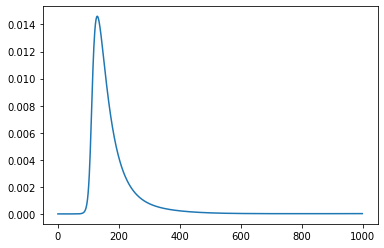

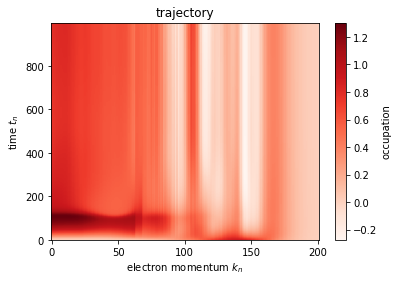

In [8]:
# ind = 6
# test_trajectory = test_trajectories[ind]

# inits = test_trajectory[:1]
# inits = np.concatenate([test_trajectory[0],[1e-6]]).reshape(1,-1)

inits = system.get_init_cond_gauss(max_pos = 0.15, width = 0.05, density=0.12, I_0=1e-6)
inits = np.concatenate([inits[:system.n_kmax],[inits[-1]]]).reshape(1,-1)

pred = integrator.integrate(inits,1000)

plt.plot(pred[:,-1])
plt.show()

derrom.utils.plot_trajectory(pred)